In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import datetime as dt
import geopy.distance

from tqdm import tqdm_notebook as tqdm
import os

import feather

In [58]:
sns.set_context("talk")
palette = sns.color_palette('colorblind')
palette_2 = sns.color_palette('Set2')
cmap = 'inferno'

# Load and prepare data

In [3]:
# Load 2018 citibike data
if os.path.isfile('data/2018_with_distance.feather'):
    #df = pd.read_csv('2018_with_distance.csv')
    df = feather.read_dataframe('data/2018_with_distance.feather')
elif os.path.isfile('data/2018.feather'):
    #df = pd.read_csv('2018.csv')
    df = feather.read_dataframe('data/2018.feather')
else:
    data_list = []
    for i in range(1, 13):
        data_list.append(pd.read_csv('data/2018{:02d}-citibike-tripdata.csv'.format(i)))
    df = pd.concat(data_list)
    #df.to_csv('2018.csv')
    feather.write_dataframe(df, 'data/2018.feather')
    
    # Drop unnamed axis and missing data
    df = df.drop(['Unnamed: 0'], axis = 1)
    df = df.dropna()
    
    # Drop userdata, where the useres are older than 3sigma away from the mean (73 years old)
    birth_mean = df['birth year'].mean() 
    birth_std = df['birth year'].std()
    df = df[df['birth year'] > int(birth_mean - 3 * birth_std)]
    
    # Drop data, where the trip duration is more than 2 hours (bike probably stolen)
    df = df.drop(df.index[(df['tripduration'] > 7200)])
    
    #Ensure data is formatted correctly to avoid errors in the visuals
    df['starttime'] = pd.to_datetime(df['starttime'])
    df['stoptime'] = pd.to_datetime(df['stoptime'])
    df['start station name'] = df['start station name'].astype('category')
    df['end station name'] = df['end station name'].astype('category')
    df['usertype'] = df['usertype'].astype('category')
    df['gender'] = df['gender'].astype('category')

/Users/fwinkler/anaconda3/envs/py3.7/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [4]:
#Percentage of missing data.
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
df_temp = feather.read_dataframe('data/2018.feather')
df_temp = df_temp.drop(['Unnamed: 0'], axis = 1)
print('Number of trips (in raw data): {}'.format(len(df_temp)))
print('Number of trips (after removing anomalies and missing values): {}'.format(len(df)))
df_miss = missing_data(df_temp)
del(df_temp)
df_miss

Number of trips (in raw data): 17548339
Number of trips (after removing anomalies and missing values): 17433085


,Total,Percent
end station name,2497,0.014229
end station id,2497,0.014229
start station name,2497,0.014229
start station id,2497,0.014229
gender,0,0.000000
birth year,0,0.000000
usertype,0,0.000000
bikeid,0,0.000000
end station longitude,0,0.000000
end station latitude,0,0.000000


In [31]:
# Calculate distance
#Combine coordinates to calculate distance based on Vincenty
if 'distance' not in df.columns:
    df_coords = pd.DataFrame()
    df_coords['start coordinates'] = list(zip(df['start station latitude'], df['start station longitude']))
    df_coords['end coordinates'] = list(zip(df['end station latitude'], df['end station longitude']))

    dist = []
    for i in tqdm(range(len(df_coords))):
        dist.append(geopy.distance.geodesic(df_coords.iloc[i]['start coordinates'],
                                            df_coords.iloc[i]['end coordinates']).m)
    np.save('distance.npy', dist)
    
    df['distance'] = dist
    
    #df.to_csv('2018_with_distance.csv')
    feather.write_dataframe(df, '2018_with_distance.feather')
    
    del(df_coords)
    del(dist)

In [32]:
# Calculate Speed
df['speed'] = df['distance'] / df['tripduration']

In [33]:
# Calculate month, weekday and hour
df['start month'] = pd.DatetimeIndex(df['starttime']).month#_name
df['start day'] = pd.DatetimeIndex(df['starttime']).day#_name
df['start weekday'] = pd.DatetimeIndex(df['starttime']).weekday_name
df['start hour'] = pd.DatetimeIndex(df['starttime']).hour

In [45]:
# Import weather data
if os.path.isfile('data/2018_weather.feather'):
    df = feather.read_dataframe('data/2018_weather.feather')
else:
    df_weather = pd.read_csv('data/weather_daily_2018.csv')
    # Select the ones you want
    df_weather = df_weather[['STATION', 'LATITUDE', 'LONGITUDE', 'DATE', 'TMAX', 'TMIN']]
    df_weather['DATE'] = pd.to_datetime(df_weather['DATE'])
    df_weather['month'] = pd.DatetimeIndex(df_weather['DATE']).month
    df_weather['day'] = pd.DatetimeIndex(df_weather['DATE']).day

    # temperature dataframe
    #temp = []
    df['tmax'] = 0
    df['tmin'] = 0
    for month in range(1, 13):
        print('Month: {}'.format(month))
        for day in tqdm(range(1, 32)):
            try:
                tmax = np.nanmean(df_weather[(df_weather['month'] == month) & (df_weather['day'] == day)]['TMAX'].values)
                tmin = np.nanmean(df_weather[(df_weather['month'] == month) & (df_weather['day'] == day)]['TMIN'].values)

                df.loc[(df['start month'] == month) & (df['start day'] == day), ['tmin', 'tmax']] = (tmin, tmax)
            except:
                print(month, day)

    feather.write_dataframe(df, 'data/2018_weather.feather')

In [6]:
print('{:.1f} % of the trips are made by Subscribers'.format(100*df['usertype'].value_counts()['Subscriber'] / len(df)))

89.1 % of the trips are made by Subscribers


# Visualization of data

## User characteristics

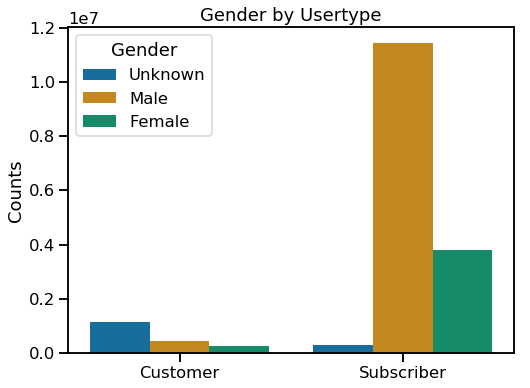

In [397]:
# usertype by gender
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.countplot(x='usertype', hue="gender", data=df, palette=palette, ax=axs)
plt.legend(title='Gender', loc='upper left', labels=['Unknown', 'Male', 'Female'])
axs.set_xlabel('')

axs.set_title('Gender by Usertype')
axs.set_ylabel('Counts');

fig.savefig('Images/gender_usertype.png', bbox_inches='tight', dpi=300)

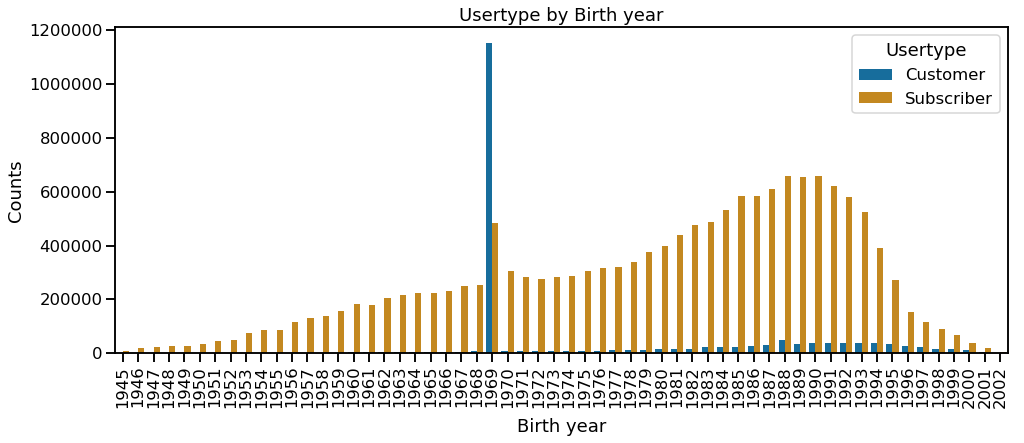

In [369]:
# Plot of birth year distribution
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(x='birth year', data=df, hue='usertype', palette=palette, 
              ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='center');
plt.legend(title='Usertype')
axs.set_title('Usertype by Birth year')

axs.set_ylabel('Counts');
axs.set_xlabel('Birth year', labelpad=10);

fig.savefig('Images/birthyear_usertype.png', bbox_inches='tight', dpi=300)

In [388]:
for ut in ['Customer', 'Subscriber']:
    n = df[df['usertype'] == ut]['birth year'].value_counts().sum()
    n_1969 = df[(df['usertype'] == ut) & (df['birth year'] == 1969)]['birth year'].value_counts().values[0]
    print('{:.1f} % of {} are born in 1969'.format(100*n_1969/n, ut))

60.9 % of Customer are born in 1969
3.1 % of Subscriber are born in 1969


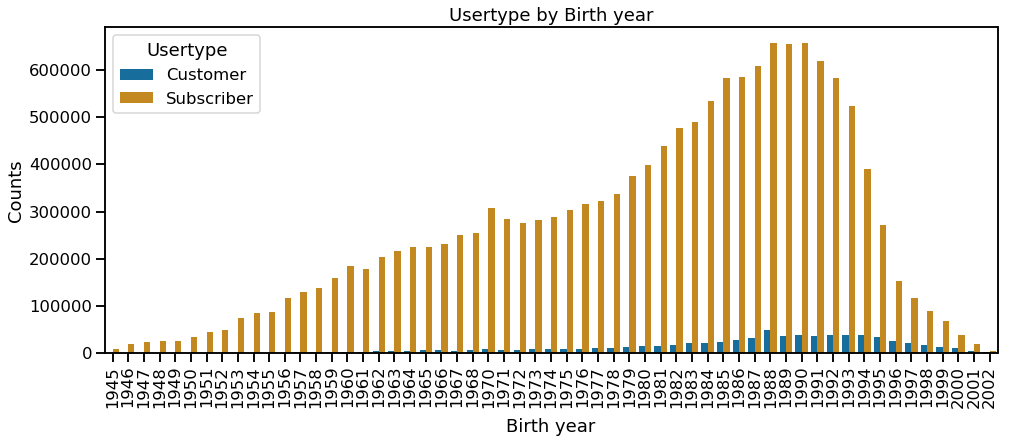

In [401]:
# Plot of birth year distribution without 1969
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(x='birth year', data=df[df['birth year'] != 1969], hue='usertype', palette=palette, 
              ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='center');
plt.legend(title='Usertype')
axs.set_title('Usertype by Birth year')

axs.set_ylabel('Counts');
axs.set_xlabel('Birth year', labelpad=10);

fig.savefig('Images/birthyear_usertype_wo1969.png', bbox_inches='tight', dpi=300)

## Trip characteristics

In [10]:
#Calculate average trip duration and trip distance
TD_user = pd.DataFrame()
TD_user['Avg. Trip Duration'] = round(df.groupby('usertype')['tripduration'].mean(),2)
TD_user['Std Trip Duration'] = round(df.groupby('usertype')['tripduration'].std(),2)
TD_user['Avg. Trip Distance'] = round(df.groupby('usertype')['distance'].mean(),2)
TD_user['Std Trip Distance'] = round(df.groupby('usertype')['distance'].std(),2)
TD_user['Avg. Trip Speed'] = round(TD_user['Avg. Trip Distance'] / TD_user['Avg. Trip Duration'], 2)
TD_user = TD_user.reset_index()
TD_user['usertype'] = TD_user['usertype'].astype('object')

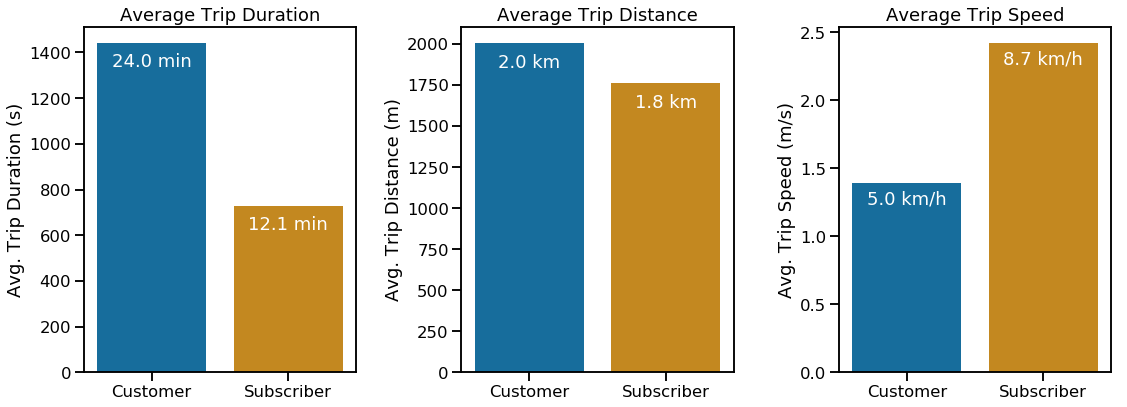

In [11]:
# Plot trip data
fig, axs = plt.subplots(1, 3, figsize=(16, 6))
plt.subplots_adjust(wspace=0.3)

# trip duration
axs[0] = sns.barplot('usertype', 'Avg. Trip Duration', data=TD_user, palette=palette, ax=axs[0], 
                     #**{'yerr':(1000, 500)}
                    )
axs[0].set_title('Average Trip Duration')
axs[0].set_ylabel('Avg. Trip Duration (s)')
for index, row in TD_user.iterrows():
    axs[0].text(index, row['Avg. Trip Duration']-100,
                '{:.1f} min'.format(row['Avg. Trip Duration'] / 60),
                color='white', ha="center")
    
# trip distance
axs[1] = sns.barplot('usertype', 'Avg. Trip Distance', data=TD_user, palette=palette, ax=axs[1])
axs[1].set_title('Average Trip Distance')
axs[1].set_ylabel('Avg. Trip Distance (m)')
for index, row in TD_user.iterrows():
    axs[1].text(index, row['Avg. Trip Distance']-150,
                '{:.1f} km'.format(row['Avg. Trip Distance'] / 1000), 
                 color='white', ha="center")
    
# trip speed
axs[2] = sns.barplot('usertype', 'Avg. Trip Speed', data=TD_user, palette=palette, ax=axs[2])
axs[2].set_title('Average Trip Speed')
axs[2].set_ylabel('Avg. Trip Speed (m/s)')
for index, row in TD_user.iterrows():
    axs[2].text(index, row['Avg. Trip Speed']-0.15,
                '{:.1f} km/h'.format(row['Avg. Trip Speed'] * 3.6), 
                 color='white', ha="center")
    
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
    ax.set_xlabel('')
    
fig.tight_layout()

fig.savefig('Images/trip_avg_data.png', bbox_inches='tight', dpi=300)

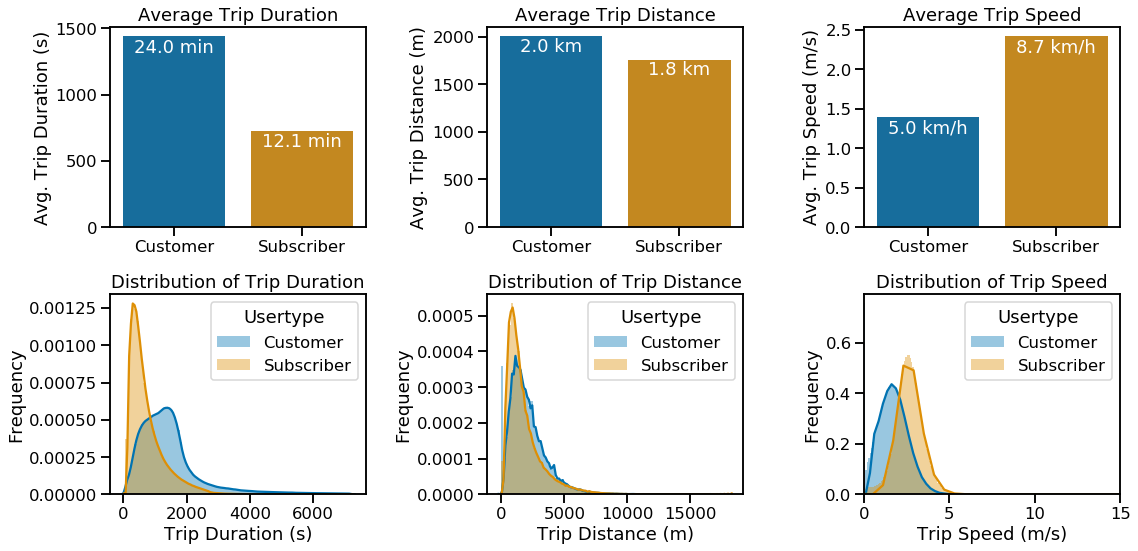

In [38]:
# Plot trip data with distributions
fig, axs = plt.subplots(2, 3, figsize=(16, 8), gridspec_kw={'height_ratios':[1, 1]})
axs = axs.ravel()

# trip duration
axs[0] = sns.barplot('usertype', 'Avg. Trip Duration', data=TD_user, palette=palette, ax=axs[0], 
                     #**{'yerr':(1000, 500)}
                    )
axs[0].set_title('Average Trip Duration')
axs[0].set_ylabel('Avg. Trip Duration (s)')
for index, row in TD_user.iterrows():
    axs[0].text(index, row['Avg. Trip Duration']-120,
                '{:.1f} min'.format(row['Avg. Trip Duration'] / 60),
                color='white', ha="center")
    
# trip distance
axs[1] = sns.barplot('usertype', 'Avg. Trip Distance', data=TD_user, palette=palette, ax=axs[1])
axs[1].set_title('Average Trip Distance')
axs[1].set_ylabel('Avg. Trip Distance (m)')
for index, row in TD_user.iterrows():
    axs[1].text(index, row['Avg. Trip Distance']-160,
                '{:.1f} km'.format(row['Avg. Trip Distance'] / 1000), 
                 color='white', ha="center")
    
# trip speed
axs[2] = sns.barplot('usertype', 'Avg. Trip Speed', data=TD_user, palette=palette, ax=axs[2])
axs[2].set_title('Average Trip Speed')
axs[2].set_ylabel('Avg. Trip Speed (m/s)')
for index, row in TD_user.iterrows():
    axs[2].text(index, row['Avg. Trip Speed']-0.2,
                '{:.1f} km/h'.format(row['Avg. Trip Speed'] * 3.6), 
                 color='white', ha="center")
    
sns.distplot(df[df['usertype'] == 'Customer']['tripduration'], bins=100, 
             label='Customer', color=palette[0], ax=axs[3])
sns.distplot(df[df['usertype'] == 'Subscriber']['tripduration'], bins=100, 
             label='Subscriber', color=palette[1], ax=axs[3])
axs[3].set_xlabel('Trip Duration (s)')
axs[3].set_ylabel('Frequency')
axs[3].legend(title='Usertype')
axs[3].set_title('Distribution of Trip Duration')

sns.distplot(df[df['usertype'] == 'Customer']['distance'], bins=100, 
             label='Customer', color=palette[0], ax=axs[4])
sns.distplot(df[df['usertype'] == 'Subscriber']['distance'], bins=100, 
             label='Subscriber', color=palette[1], ax=axs[4])
axs[4].set_xlabel('Trip Distance (m)')
axs[4].set_ylabel('Frequency')
axs[4].legend(title='Usertype')
axs[4].set_title('Distribution of Trip Distance')

sns.distplot(df[df['usertype'] == 'Customer']['speed'], bins=np.linspace(0, 8, 100), 
             label='Customer', color=palette[0], ax=axs[5])
sns.distplot(df[df['usertype'] == 'Subscriber']['speed'], bins=np.linspace(0, 8, 100), 
             label='Subscriber', color=palette[1], ax=axs[5])
axs[5].set_xlim(0, 15)
axs[5].set_xlabel('Trip Speed (m/s)')
axs[5].set_ylabel('Frequency')
axs[5].legend(title='Usertype')
axs[5].set_title('Distribution of Trip Speed')
    
for ax in axs[:3]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
    ax.set_xlabel('')
    fig.tight_layout()
    
fig.savefig('Images/trip_avg_data_with_distributions.png', bbox_inches='tight', dpi=300)

Subscribers ride shorter trips

Subscribers are faster than Customers

Distance is similar for both

## station characteristics

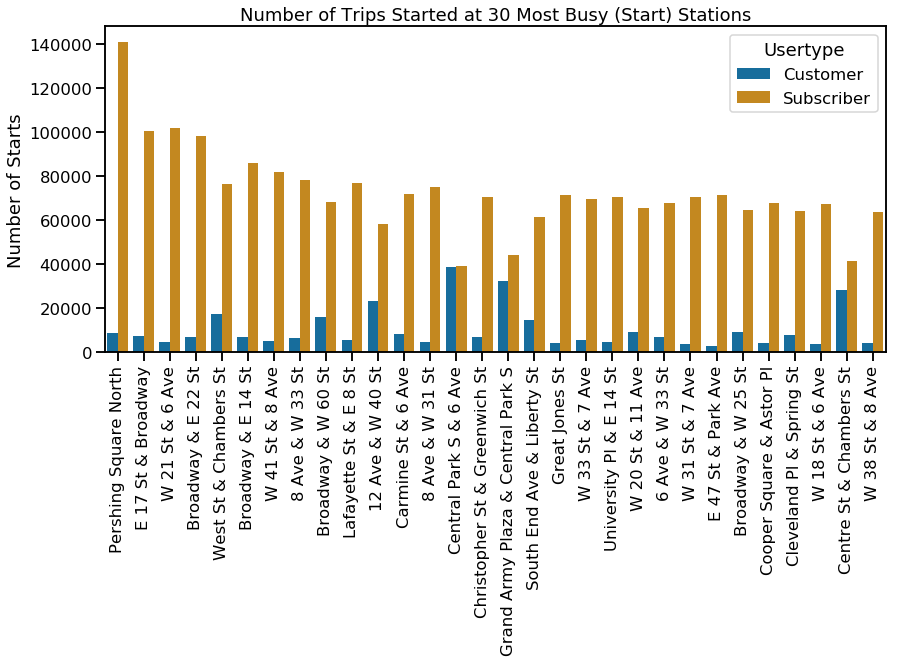

In [396]:
# 30 most busy start stations
fig, axs = plt.subplots(1, 1, figsize=(14, 6))
sns.countplot(x='start station name', hue="usertype", palette=palette, data=df, 
              order=df['start station name'].value_counts().iloc[:30].index, ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha = 'center');

plt.legend(title='Usertype')

axs.set_title('Number of Trips Started at 30 Most Busy (Start) Stations')
axs.set_ylabel('Number of Starts');
axs.set_xlabel('')

fig.savefig('Images/start_stations_30.png', bbox_inches='tight', dpi=300)

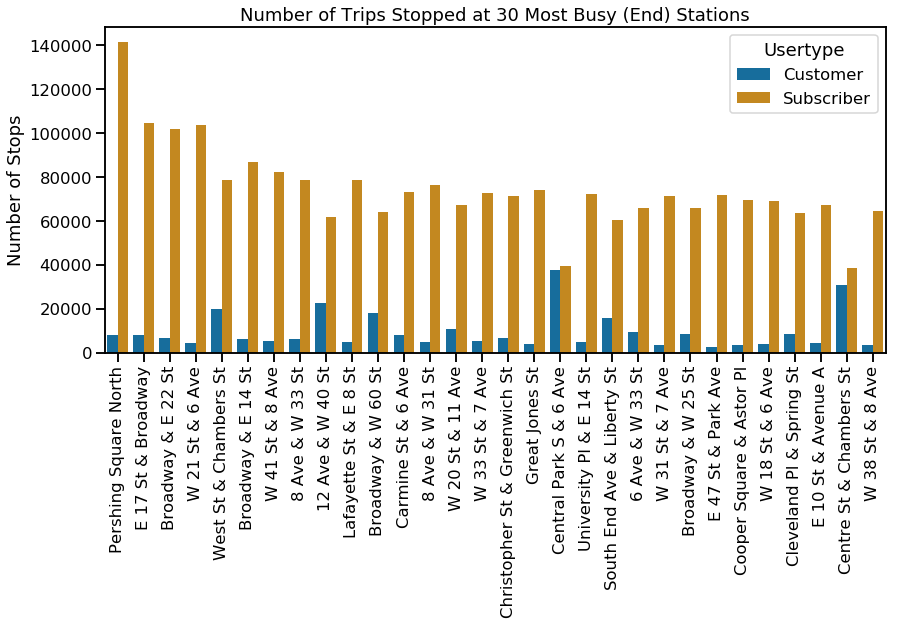

In [398]:
# 30 most busy end stations
fig, axs = plt.subplots(1, 1, figsize=(14, 6))
sns.countplot(x='end station name', hue="usertype", palette=palette, data=df, 
              order=df['end station name'].value_counts().iloc[:30].index, ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha = 'center');

plt.legend(title='Usertype')

axs.set_title('Number of Trips Stopped at 30 Most Busy (End) Stations')
axs.set_ylabel('Number of Stops');
axs.set_xlabel('')

fig.savefig('Images/end_stations_30.png', bbox_inches='tight', dpi=300)

## Time characteristics

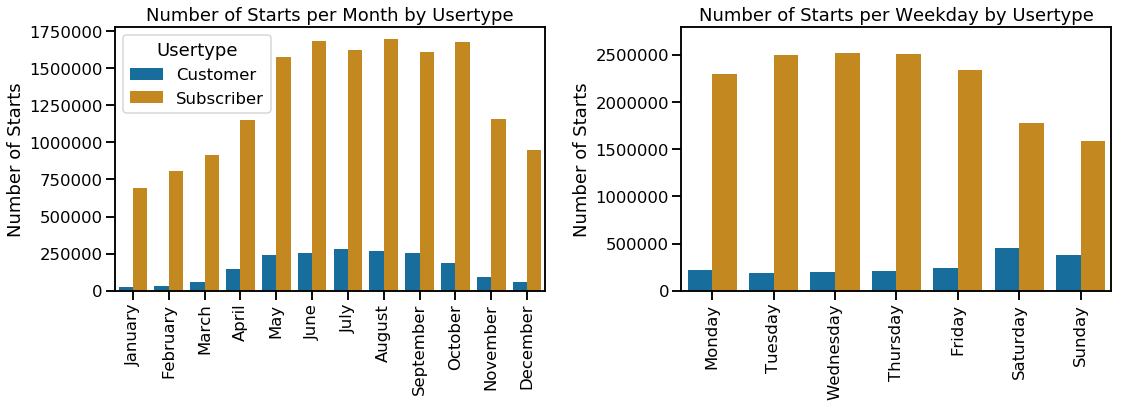

In [423]:
# usertype by start time - month and weekday
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(x='start month', hue="usertype", data=df, palette=palette, ax=axs[0])

axs[0].set_title('Number of Starts per Month by Usertype')
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 
          'August', 'September', 'October', 'November', 'December']

axs[0].set_xticklabels(months, rotation=90, ha='center')
axs[0].set_ylabel('Number of Starts');
axs[0].legend(title='Usertype')
axs[0].set_xlabel('')

cplt = sns.countplot(x='start weekday', hue="usertype", data=df, palette=palette, ax=axs[1], )
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90, ha='center');
axs[1].set_title('Number of Starts per Weekday by Usertype')
axs[1].set_ylabel('Number of Starts');
axs[1].set_xlabel('')
axs[1].set_ylim(0, 2800000)
axs[1].legend(title='Usertype')
cplt.legend_.remove()
fig.tight_layout()

fig.savefig('Images/month_weekday.png', bbox_inches='tight', dpi=300)

Customers use the bikes more in summer.
Subscribers use the bikes more in summer.

Customers use the bikes more stronly on weekends
Subscribers use the bikes less on weekends.

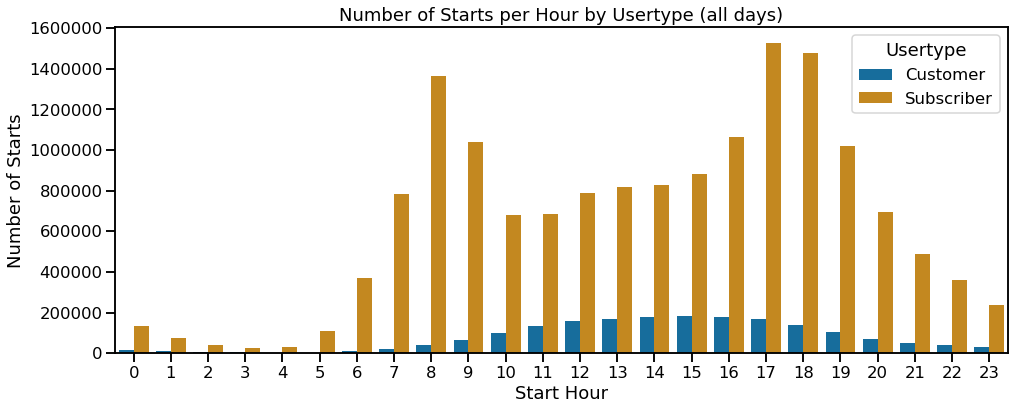

In [427]:
# usertype by start time - month and weekday
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(x='start hour', hue="usertype", data=df, palette=palette, ax=axs)
axs.legend(title='Usertype')
axs.set_xlabel('Start Hour')
axs.set_title('Number of Starts per Hour by Usertype (all days)')
axs.set_ylabel('Number of Starts');

fig.savefig('Images/hours_mo_su.png', bbox_inches='tight', dpi=300)

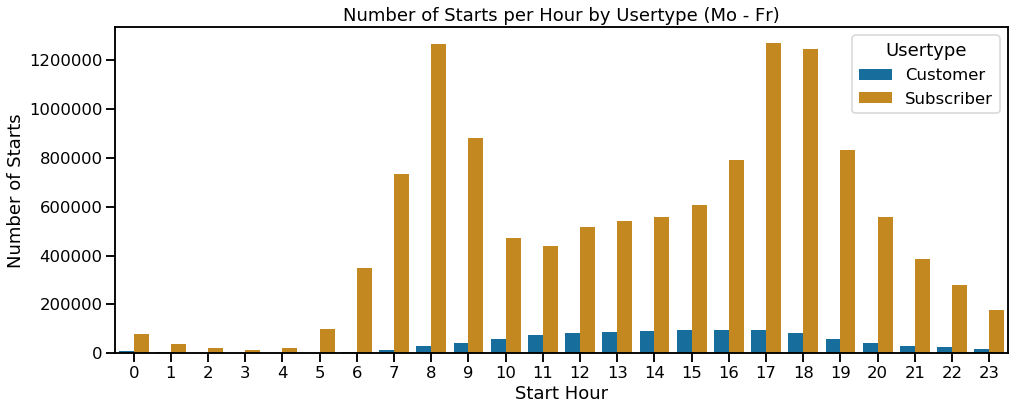

In [428]:
# usertype by start time - month and weekday
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(x='start hour', hue="usertype", palette=palette, ax=axs,
              data=df[(df['start weekday'] != 'Saturday') & (df['start weekday'] != 'Sunday')])
axs.legend(title='Usertype')
axs.set_xlabel('Start Hour')
axs.set_title('Number of Starts per Hour by Usertype (Mo - Fr)')
axs.set_ylabel('Number of Starts');

fig.savefig('Images/hours_mo_fr.png', bbox_inches='tight', dpi=300)

In [39]:
trips_weekend = len(df[(df['start weekday'] == 'Saturday') | (df['start weekday'] == 'Sunday')])
trips_tot = len(df)
print('{} ({:.1f} %) trips were made on weekends'.format(trips_weekend, 100*trips_weekend/trips_tot))

4200002 (24.1 %) trips were made on weekends


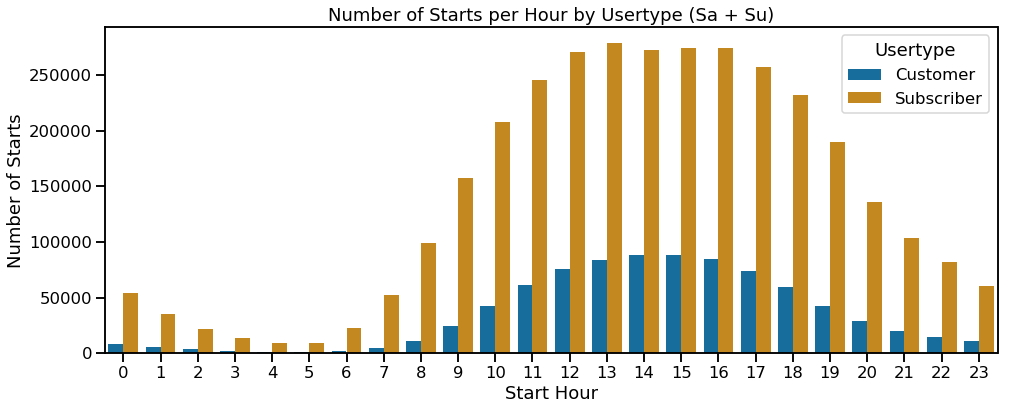

In [431]:
# usertype by start time - month and weekday
fig, axs = plt.subplots(1, 1, figsize=(16, 6))
sns.countplot(x='start hour', hue="usertype", palette=palette, ax=axs,
              data=df[(df['start weekday'] == 'Saturday') | (df['start weekday'] == 'Sunday')])
axs.legend(title='Usertype')
axs.set_xlabel('Start Hour')
axs.set_title('Number of Starts per Hour by Usertype (Sa + Su)')
axs.set_ylabel('Number of Starts');

fig.savefig('Images/hours_sa_su.png', bbox_inches='tight', dpi=300)

## Routes heatmap

In [446]:
cross_cust = pd.crosstab(df[df['usertype'] == 'Customer']['start station name'], 
                    df[df['usertype'] == 'Customer']['end station name'])
cross_subs = pd.crosstab(df[df['usertype'] == 'Subscriber']['start station name'], 
                    df[df['usertype'] == 'Subscriber']['end station name'])

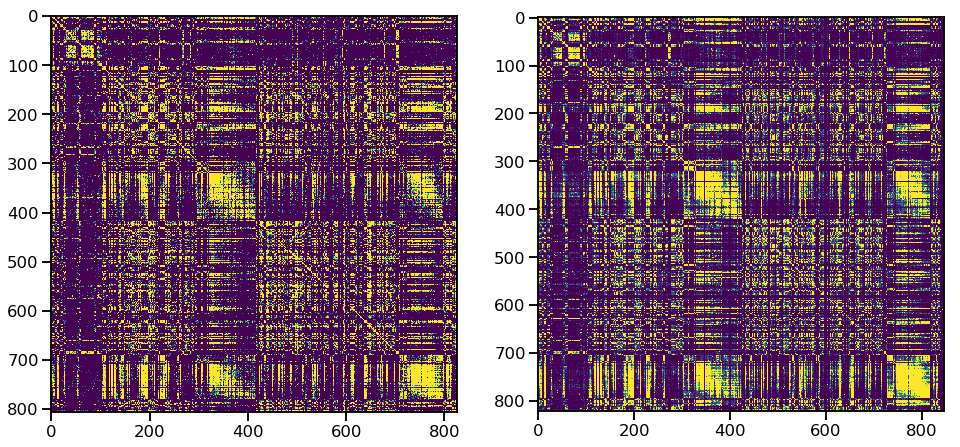

In [449]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(cross_cust.values, clim=(0, np.mean(cross_cust.values)))
axs[1].imshow(cross_subs.values, clim=(0, np.mean(cross_subs.values)))
#plt.colorbar()

# Building Models

In [573]:
# Imports for model fitting
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from joblib import dump, load # for saving and loading models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, f1_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import learning_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import make_pipeline, Pipeline

## Data preparation for scikit-learn

In [459]:
# Drop all unrelevant columns and store new dataframe
if input('Load data for modeling? (y or n)') == 'y':
    df_model = feather.read_dataframe('data/2018_model_1.feather')
else:
    df_model = df.copy()

    #df_model.drop('starttime')
    df_model = df_model.drop(['starttime'], axis = 1)
    df_model = df_model.drop(['stoptime'], axis = 1)
    df_model = df_model.drop(['start station latitude'], axis = 1)
    df_model = df_model.drop(['start station longitude'], axis = 1)
    df_model = df_model.drop(['start station name'], axis = 1)
    df_model = df_model.drop(['end station latitude'], axis = 1)
    df_model = df_model.drop(['end station longitude'], axis = 1)
    df_model = df_model.drop(['end station name'], axis = 1)
    df_model = df_model.drop(['bikeid'], axis = 1)
    #df_model = df_model.drop(['start month'], axis = 1)
    #df_model = df_model.drop(['distance'], axis = 1)

    # replace weekday strings by numbers
    df_model['start weekday'] = pd.DatetimeIndex(df['starttime']).weekday

    feather.write_dataframe(df_model, 'data/2018_model_1.feather')

Load data for modeling? (y or n)y


/Users/fwinkler/anaconda3/envs/py3.7/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [461]:
# Prepare model dataframe as vectors for scikit learn
feature_cols = ['tripduration', 'speed',
                'start station id', 'end station id',
                'start weekday', 'start hour',
                'birth year', 'gender']

# you want all rows, and the feature_cols' columns
X = df_model.loc[:, feature_cols]
Y = df_model.loc[:, 'usertype']

In [495]:
# Create balanced dataset
x_cust = X[Y == 'Customer']
y_cust = Y[Y == 'Customer']

x_subs = X[Y == 'Subscriber']
y_subs = Y[Y == 'Subscriber']

# Shuffle subscriber data
x_subs = x_subs.sample(frac=1, random_state=42)

x_subs = x_subs.head(len(y_cust))
y_subs = y_subs[x_subs.index]
#y_subs = y_subs.head(len(y_cust))

x_bal = pd.concat((x_cust, x_subs))
y_bal = pd.concat((y_cust, y_subs))

## Naive Bayes

### unbalanced data set

In [512]:
model = GaussianNB()
model_name = 'model_bayes'

# split the data with 50% in each set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

In [513]:
# Grid search
if input('Load grid search results? (y or n)') == 'y':
    grid = load('grids/grid_{}.joblib'.format(model_name))
else:
    param_grid = {'var_smoothing': [1e-5, 1e-7, 1e-9, 1e-11, 1e-13, 1e-15]}
    grid = GridSearchCV(model, param_grid, n_jobs=2, verbose=2, return_train_score=True)

    %time grid.fit(X_train, Y_train)
    
    dump(grid, 'grids/grid_{}.joblib'.format(model_name)) 
    
# Print grid search results
print(grid.best_params_)
print('Score: ', grid.cv_results_['mean_train_score'])
print('Time: ', grid.cv_results_['mean_fit_time'])

# Build model with best params
model = grid.best_estimator_

Load grid search results? (y or n)y
{'var_smoothing': 1e-13}
Score:  [0.87870514 0.90702763 0.92197058 0.92206609 0.92206733 0.92206743]
Time:  [11.61801298 10.1968023  10.6079886  11.15993857  9.57329186 10.57472968]


In [514]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_bayes"? (y or n)y


In [515]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Load cross validation score? (y or n)y
[0.92241726 0.92248527 0.92224309 0.92206892 0.92221274]


In [516]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

Customer 0.597337217217851
Subscriber 0.9618172060835258


In [517]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

0.9221975291645771
0.7795772116506885


In [518]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

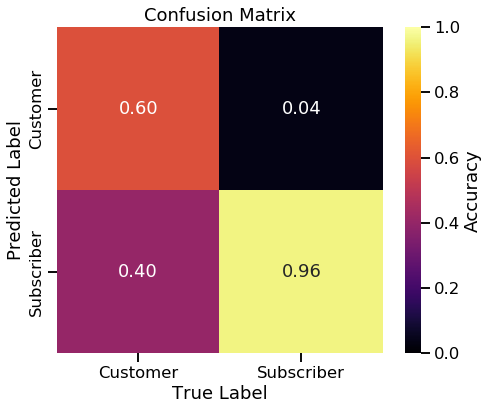

In [521]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

In [91]:
# Calculate probabilities of usertype prediction
yprob = model.predict_proba(X_test)
#yprob[:20]

### balanced data set

In [522]:
model = GaussianNB()
model_name = 'model_bayes_balanced'

# split the data with 50% in each set
X_train, X_test, Y_train, Y_test = train_test_split(x_bal, y_bal, test_size=0.5, random_state=42)

In [523]:
# Grid search
if input('Load grid search results? (y or n)') == 'y':
    grid = load('grids/grid_{}.joblib'.format(model_name))
else:
    param_grid = {'var_smoothing': [1e-5, 1e-7, 1e-9, 1e-11, 1e-13, 1e-15]}
    grid = GridSearchCV(model, param_grid, n_jobs=2, verbose=2, return_train_score=True)

    %time grid.fit(X_train, Y_train)
    
    dump(grid, 'grids/grid_{}.joblib'.format(model_name)) 
    
# Print grid search results
print(grid.best_params_)
print('Score: ', grid.cv_results_['mean_train_score'])
print('Time: ', grid.cv_results_['mean_fit_time'])

# Build model with best params
model = grid.best_estimator_

Load grid search results? (y or n)y
{'var_smoothing': 1e-11}
Score:  [0.698298   0.81221197 0.82584278 0.82596019 0.82596178 0.82596178]
Time:  [3.31653857 3.83560475 3.30544662 3.30295428 3.44152133 3.36444569]


In [524]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_bayes_balanced"? (y or n)y


In [525]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Load cross validation score? (y or n)y
[0.82562143 0.82582987 0.82498199 0.82496616 0.82505059]


In [503]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

Customer 0.7629280666404769
Subscriber 0.8875260131824736


In [527]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

0.8252646821202432
0.8252270399114752


In [528]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

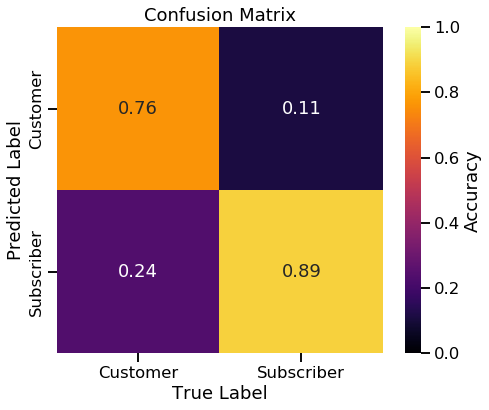

In [529]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

## Random Forests

### validation curves

In [627]:
# Run validation curve for depth of trees 
try:
    train_score = np.load('train_score_valcurve_max_depth_forrest.npy')
    val_score = np.load('val_score_valcurve_max_depth_forrest.npy')
    max_depth = [2, 4, 6, 10, 15, 20, 30, 50]
except:
    model = RandomForestClassifier(n_estimators=40, max_depth=20, random_state=0, verbose=10, n_jobs=2)

    max_depth = [2, 4, 6, 10, 15, 20, 30, 50]
    train_score_2, val_score_2 = validation_curve(model, x_bal, y_bal,
                                              'max_depth', 
                                              max_depth, cv=5)
    np.save('train_score_valcurve_max_depth_forrest.npy', train_score_2)
    np.save('val_score_valcurve_max_depth_forrest.npy', val_score_2)

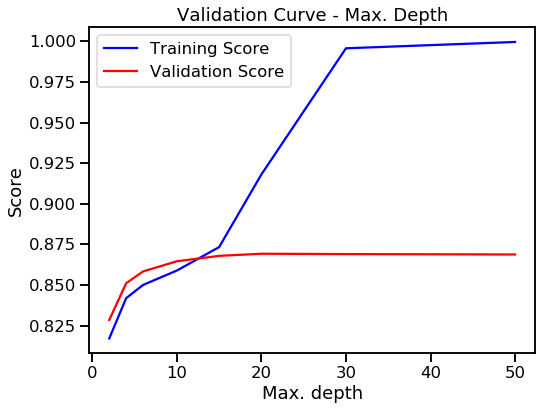

In [628]:
# Plot validation curve  depth of trees
fig, axs = plt.subplots(1, 1, figsize=(8, 6)) 

sns.lineplot(max_depth, np.median(train_score_2, 1), color='blue', label='Training Score')
sns.lineplot(max_depth, np.median(val_score_2, 1), color='red', label='Validation Score')

axs.legend(loc='best')
#axs.set_ylim(0, 1)
axs.set_xlabel('Max. depth')
axs.set_ylabel('Score');
axs.set_title('Validation Curve - Max. Depth')

fig.savefig('Images/val_curve_depth_forrests.png', bbox_inches='tight', dpi=300)

In [761]:
# Run validation curve for number of estimators
try:
    train_score = np.load('train_score_valcurve_n_estimators_forrest.npy')
    val_score = np.load('val_score_valcurve_n_estimators_forrest.npy')
    n_estimators = [20, 40, 60, 100, 150, 200]
except:
    model = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=0, verbose=10, n_jobs=2)

    n_estimators = [20, 40, 60, 100, 150, 200]
    train_score, val_score = validation_curve(model, x_bal, y_bal,
                                              'n_estimators', 
                                              n_estimators, cv=3)
    np.save('train_score_valcurve_n_estimators_forrest.npy', train_score)
    np.save('val_score_valcurve_n_estimators_forrest.npy', val_score)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   50.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.7min finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   47.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.0min
[Parallel(n_jobs=2)]: Do

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    8.9s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.7s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:   16.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   47.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done  28 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   12.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   19.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   23.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   24.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   47.6s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   20.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   21.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   23.4s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   27.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   32.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   37.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   40.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.2s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   19.8s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   22.8s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   25.8s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   29.7s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   23.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   27.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   32.7s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   37.6s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   49.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   55.8s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   22.8s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   25.8s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   29.2s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   23.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   27.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   32.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   37.5s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   43.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   49.1s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   56.1s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.4s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.2s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   49.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.3min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.1min
[Parallel(n_jobs=2)]: Do

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    8.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   48.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  28 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   12.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.2s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   22.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   23.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   48.8s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.4s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.0s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   19.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   20.9s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   22.6s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   26.8s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   31.8s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   36.7s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   39.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    5.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    7.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   11.9s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   16.8s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   19.4s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   22.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   25.4s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   28.8s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   22.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   26.8s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   31.8s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   36.7s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   42.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   48.0s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   54.4s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.1s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   19.8s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   22.8s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   25.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   29.2s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   22.7s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   26.8s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   31.9s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   36.7s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   42.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   48.0s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   54.4s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   50.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.3min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  2.1min
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:  2.6min
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=2)]: Do

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:    8.5s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  40 out of  40 | elapsed:   15.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   48.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done  28 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   12.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   21.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:   22.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   49.0s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.8s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   15.1s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.8s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   20.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   21.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   21.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   25.6s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   30.5s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   35.2s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   37.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.6s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   20.3s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   23.4s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   26.4s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   29.9s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    9.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   12.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   16.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   20.2s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   25.2s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   29.9s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   35.1s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   39.9s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   45.9s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   51.3s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   57.8s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   12.3s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   14.7s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   17.4s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   23.1s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   26.2s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   29.7s
[Para

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    8.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:   10.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   14.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   17.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:   21.5s
[Parallel(n_jobs=2)]: Done  68 tasks      | elapsed:   25.5s
[Parallel(n_jobs=2)]: Done  81 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done  94 tasks      | elapsed:   35.0s
[Parallel(n_jobs=2)]: Done 109 tasks      | elapsed:   40.5s
[Parallel(n_jobs=2)]: Done 124 tasks      | elapsed:   45.9s
[Parallel(n_jobs=2)]: Done 141 tasks      | elapsed:   52.2s
[Para

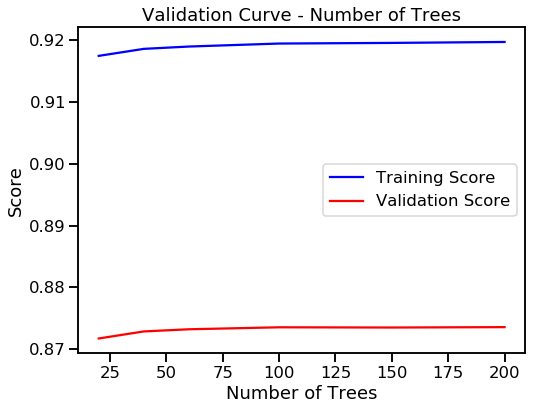

In [763]:
# Plot validation curve  depth of trees
fig, axs = plt.subplots(1, 1, figsize=(8, 6)) 

sns.lineplot(n_estimators, np.median(train_score, 1), color='blue', label='Training Score')
sns.lineplot(n_estimators, np.median(val_score, 1), color='red', label='Validation Score')

axs.legend(loc='best')
#axs.set_ylim(0, 1)
axs.set_xlabel('Number of Trees')
axs.set_ylabel('Score');
axs.set_title('Validation Curve - Number of Trees')

fig.savefig('Images/val_curve_n_trees_forrests.png', bbox_inches='tight', dpi=300)

### Unbalanced data

In [543]:
model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42, verbose=2, n_jobs=2)
model_name = 'model_forest'

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

In [544]:
# Grid search
if input('Load grid search results? (y or n)') == 'y':
    grid = load('grids/grid_{}.joblib'.format(model_name))
else:
    param_grid = {'n_estimators': [40, 60, 80],
                  'max_depth': [10, 15]
                  #'max_samples': [0.4, 0.8]
                 }
    grid = GridSearchCV(model, param_grid, n_jobs=2, verbose=2, return_train_score=True, cv=2)

    %time grid.fit(X_train, Y_train)
    
    dump(grid, 'grids/grid_{}.joblib'.format(model_name)) 
    
# Print grid search results
print(grid.best_params_)
print('Score: ', grid.cv_results_['mean_train_score'])
print('Time: ', grid.cv_results_['mean_fit_time'])

# Build model with best params
model = grid.best_estimator_

Load grid search results? (y or n)y
{'max_depth': 20, 'n_estimators': 60}
Score:  [0.94949439 0.94969597 0.94976291 0.95079674 0.95086019 0.95083562
 0.96657096 0.96651506 0.96650886]
Time:  [ 82.04345357 178.37050998 252.06748903 130.73013794 219.54182398
 323.22928405 168.53864694 445.59624398 628.14688504]


In [545]:
print(grid.cv_results_['param_max_depth'])
print(grid.cv_results_['param_n_estimators'])
model = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=42, verbose=2, n_jobs=2)

[6 6 6 10 10 10 20 20 20]
[20 40 60 20 40 60 20 40 60]


In [546]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_forest"? (y or n)n


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  5.5min finished


In [551]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Load cross validation score? (y or n)y
[0.95244503 0.95239611 0.95275841 0.95247196 0.95261829]


In [547]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.7s finished


Customer 0.6275225083621873


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   41.9s finished


Subscriber 0.9901089057451773


In [548]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:   47.1s finished


0.950695065868185
0.8088157070536823


In [549]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

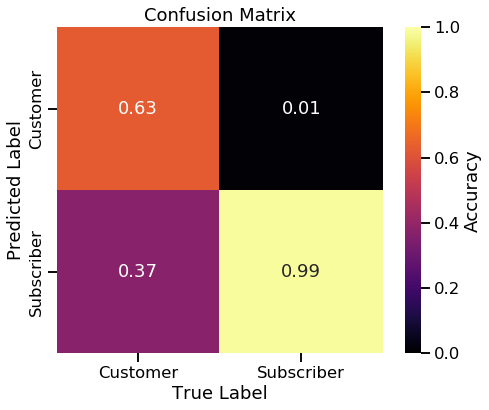

In [550]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

### balanced data

In [552]:
model = RandomForestClassifier(n_estimators=100, random_state=0, verbose=10, n_jobs=2)
model_name = 'model_forest_balanced'

X_train, X_test, Y_train, Y_test = train_test_split(x_bal, y_bal, test_size=0.5, random_state=42)

In [553]:
# Grid search
if input('Load grid search results? (y or n)') == 'y':
    grid = load('grids/grid_{}.joblib'.format(model_name))
else:
    param_grid = {'n_estimators': [20, 40, 60],
                  'max_depth': [6, 10, 20]
                  #'max_samples': [0.4, 0.8]
                 }
    grid = GridSearchCV(model, param_grid, n_jobs=2, verbose=2, return_train_score=True, cv=2)

    %time grid.fit(X_train, Y_train)
    
    dump(grid, 'grids/grid_{}.joblib'.format(model_name)) 
    
# Print grid search results
print(grid.best_params_)
print('Score: ', grid.cv_results_['mean_train_score'])
print('Time: ', grid.cv_results_['mean_fit_time'])

# Build model with best params
model = grid.best_estimator_

Load grid search results? (y or n)y
{'max_depth': 20, 'n_estimators': 60}
Score:  [0.85024827 0.85183563 0.85242444 0.86156262 0.86186128 0.86187034
 0.94104186 0.94332003 0.94397968]
Time:  [ 27.72316301  47.86242652  72.51405382  35.81522059  75.66197121
 109.99213159  47.66857326  93.56835151 137.84270847]


In [554]:
model = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=42, verbose=2, n_jobs=2)

In [555]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_forest_balanced"? (y or n)n


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 20building tree 2 of 20

building tree 3 of 20
building tree 4 of 20
building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.8min finished


In [564]:
for i in range(len(feature_cols)):
    print(feature_cols[i], np.round(model.feature_importances_[i], 2))

tripduration 0.17
speed 0.2
start station id 0.04
end station id 0.04
start weekday 0.04
start hour 0.04
birth year 0.16
gender 0.32


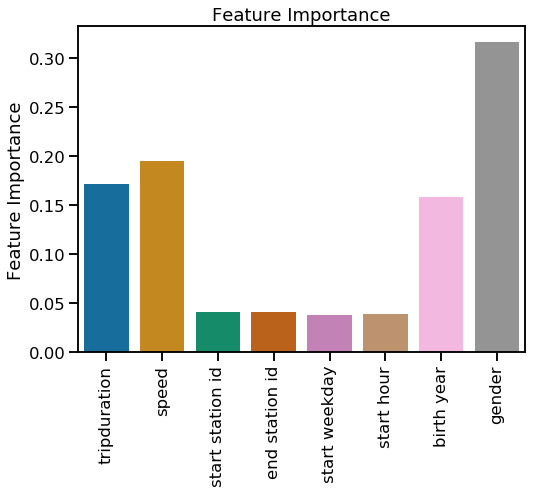

In [571]:
# Plot feature importancs
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(feature_cols, model.feature_importances_, palette=palette, ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='center', );
axs.set_xlabel('')
axs.set_ylabel('Feature Importance')
axs.set_title('Feature Importance')

fig.savefig('Images/feature_importance_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

In [558]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Load cross validation score? (y or n)y
[0.86559691 0.86550624 0.86452507 0.86600985 0.8653383 ]


In [559]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.7s finished


Customer 0.8363884629519331


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.7s finished


Subscriber 0.8991917323171008


In [560]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    7.4s finished


0.867809071091483
0.867790097634517


In [561]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

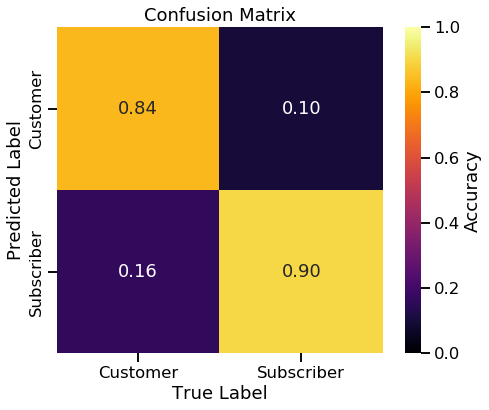

In [562]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

In [252]:
# learning curve
model = RandomForestClassifier(n_estimators=60, max_depth=10, random_state=0, verbose=10, n_jobs=2)

N, train_lc, val_lc = learning_curve(model,
                                     x_bal, y_bal, cv=5,
                                     shuffle=True,
                                     train_sizes=[0.05, 0.1, 0.2, 0.3, 0.4])

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    6.2s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    8.5s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.1s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   11.6s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    4.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   19.6s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.9s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    5.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1856s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.9s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.0s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    6.8s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    5.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    8.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   18.7s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    4.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    6.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1971s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.1s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.0s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    1.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    9.4s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.0s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   15.7s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.9s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    3.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    7.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    7.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.0s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    1.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    6.1s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.4s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    6.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   16.0s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.0s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    4.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.1703s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: 

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    3.2s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    4.4s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    0.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.7s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    1.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.6s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.6s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.9s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.3s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    3.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    6.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:   16.5s
[Parallel(n_jobs=2)]: Done  14 tasks      |

Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.0s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    1.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    2.6s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    2.8s finished


Using ThreadingBackend as joblib.Parallel backend instead of LokyBackend as the latter does not provide shared memory semantics.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    1.1s
[Parallel(n_jobs=2)]: Done  21 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done  28 tasks      | elapsed:    2.2s
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    2.9s
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=2)]: Done  57 tasks      | elapsed:    4.5s
[Parallel(n_jobs=2)]: Done  60 out of  60 | elapsed:    4.7s finished


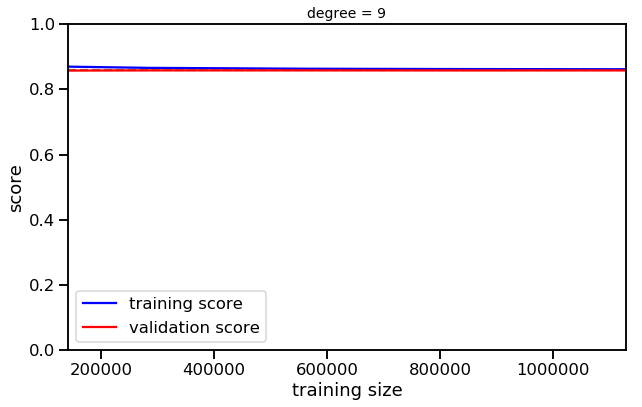

In [254]:
# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1],
             color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('training size')
ax.set_ylabel('score')
ax.set_title('degree = {0}'.format(degree), size=14)
ax.legend(loc='best')

## multilayer perceptron

### unbalanced data

In [585]:
# Build model
scaler = StandardScaler()

mlp = MLPClassifier(solver='adam', alpha=1e-3, max_iter=100,
                    hidden_layer_sizes=(10, 10,), random_state=42, verbose=2)

#model = make_pipeline(scaler, mlp)
model = Pipeline(steps=[('scaler', scaler), ('mlp', mlp)])

model_name = 'model_mpl'
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.7, random_state=42)

In [586]:
# Grid search
if input('Load grid search results? (y or n)') == 'y':
    grid = load('grids/grid_{}.joblib'.format(model_name))
else:
    param_grid = {'mlp__alpha': [1e-1, 1e-2, 1e-3, 1e-4],
                  'mlp__hidden_layer_sizes': [(9,), (9, 9,), (9, 9, 9,), (18,), (18, 18,)]
                  #'max_samples': [0.4, 0.8]
                 }
    grid = GridSearchCV(model, param_grid, n_jobs=2, verbose=2, return_train_score=True, cv=2)

    %time grid.fit(X_train, Y_train)
    
    dump(grid, 'grids/grid_{}.joblib'.format(model_name)) 
    
# Print grid search results
print(grid.best_params_)
print('Score: ', grid.cv_results_['mean_train_score'])
print('Time: ', grid.cv_results_['mean_fit_time'])

# Build model with best params
model = grid.best_estimator_

Load grid search results? (y or n)y
{'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (18, 18)}
Score:  [0.94857915 0.94933189 0.94985654 0.94891847 0.94970719 0.9490477
 0.95008289 0.94994166 0.94973931 0.95063946 0.94903648 0.95021908
 0.9502067  0.94978709 0.95064526 0.94905215 0.95009314 0.95028582
 0.94978632 0.95086774]
Time:  [ 81.10758805 130.12849212 193.90708852  77.26657999 148.8729645
  75.12044513 125.33766401 184.95281398 130.85116601 188.19653141
  76.67976844 147.92662251 159.99518275 135.75366795 143.77057195
  77.33654249 114.94412351 225.55123734 126.52402771 153.55915058]


In [587]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_mpl"? (y or n)n
Iteration 1, loss = 0.16089943
Iteration 2, loss = 0.15722425
Iteration 3, loss = 0.15601106
Iteration 4, loss = 0.15534904
Iteration 5, loss = 0.15516875
Iteration 6, loss = 0.15500318
Iteration 7, loss = 0.15490686
Iteration 8, loss = 0.15479547
Iteration 9, loss = 0.15477834
Iteration 10, loss = 0.15473467
Iteration 11, loss = 0.15471606
Iteration 12, loss = 0.15467572
Iteration 13, loss = 0.15465652
Iteration 14, loss = 0.15462878
Iteration 15, loss = 0.15458441
Iteration 16, loss = 0.15453148
Iteration 17, loss = 0.15448378
Iteration 18, loss = 0.15445209
Iteration 19, loss = 0.15441134
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [580]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Load cross validation score? (y or n)y
[0.95066081 0.95079969 0.95118893 0.9508121  0.95078723]


In [581]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

Customer 0.6053989914866639
Subscriber 0.9901648052944229


In [588]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

0.9490908092657967
0.8057181790716852


In [589]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

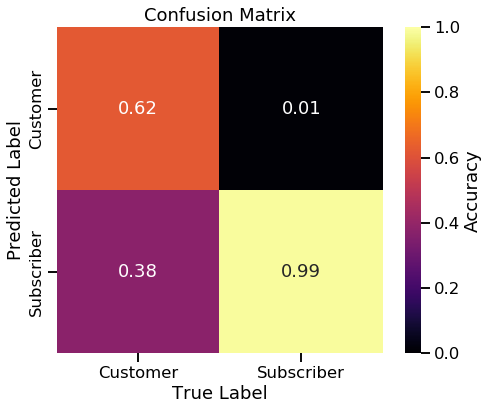

In [590]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

### balanced data

In [591]:
# Build model
scaler = StandardScaler()

mlp = MLPClassifier(solver='adam', alpha=1e-3, max_iter=100,
                    hidden_layer_sizes=(10, 10,), random_state=42, verbose=2)

#model = make_pipeline(scaler, mlp)
model = Pipeline(steps=[('scaler', scaler), ('mlp', mlp)])

model_name = 'model_mpl_balanced'
X_train, X_test, Y_train, Y_test = train_test_split(x_bal, y_bal, test_size=0.5, random_state=42)

In [592]:
# Grid search
if input('Load grid search results? (y or n)') == 'y':
    grid = load('grids/grid_{}.joblib'.format(model_name))
else:
    param_grid = {'mlp__alpha': [1e-1, 1e-2, 1e-3, 1e-4],
                  'mlp__hidden_layer_sizes': [(9,), (9, 9,), (9, 9, 9,), (18,), (18, 18,)]
                  #'max_samples': [0.4, 0.8]
                 }
    grid = GridSearchCV(model, param_grid, n_jobs=2, verbose=2, return_train_score=True, cv=2)

    %time grid.fit(X_train, Y_train)
    
    dump(grid, 'grids/grid_{}.joblib'.format(model_name)) 
    
# Print grid search results
print(grid.best_params_)
print('Score: ', grid.cv_results_['mean_train_score'])
print('Time: ', grid.cv_results_['mean_fit_time'])

# Build model with best params
model = grid.best_estimator_

Load grid search results? (y or n)y
{'mlp__alpha': 0.001, 'mlp__hidden_layer_sizes': (18, 18)}
Score:  [0.85510157 0.85838622 0.85847859 0.8563948  0.85864804 0.85640614
 0.85888095 0.85941819 0.85724883 0.86100838 0.85693318 0.85805469
 0.85951567 0.85770957 0.86110529 0.85683854 0.85806716 0.85969078
 0.85739788 0.86091261]
Time:  [ 29.31960762  56.41275406  93.64703953  30.58846056  54.11564493
  35.75696361  75.34464359 104.23697352  39.02601206 104.48253751
  43.76025045  69.40670252 103.13301432  37.96583283  90.20922804
  39.37471712 100.25860548 118.00392306  34.13080359  68.09418261]


In [593]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_mpl_balanced"? (y or n)n
Iteration 1, loss = 0.32956527
Iteration 2, loss = 0.31766032
Iteration 3, loss = 0.31506256
Iteration 4, loss = 0.31371655
Iteration 5, loss = 0.31299687
Iteration 6, loss = 0.31255563
Iteration 7, loss = 0.31216690
Iteration 8, loss = 0.31178553
Iteration 9, loss = 0.31144791
Iteration 10, loss = 0.31122934
Iteration 11, loss = 0.31104983
Iteration 12, loss = 0.31081746
Iteration 13, loss = 0.31067057
Iteration 14, loss = 0.31046742
Iteration 15, loss = 0.31033195
Iteration 16, loss = 0.31027260
Iteration 17, loss = 0.31018265
Iteration 18, loss = 0.31019771
Iteration 19, loss = 0.31008940
Iteration 20, loss = 0.31004213
Iteration 21, loss = 0.31000645
Iteration 22, loss = 0.30994308
Iteration 23, loss = 0.30987009
Iteration 24, loss = 0.30984042
Iteration 25, loss = 0.30977497
Iteration 26, loss = 0.30975638
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


In [262]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Iteration 1, loss = 0.34008696
Iteration 2, loss = 0.32647115
Iteration 3, loss = 0.32456763
Iteration 4, loss = 0.32337901
Iteration 5, loss = 0.32252724
Iteration 6, loss = 0.32189989
Iteration 7, loss = 0.32136508
Iteration 8, loss = 0.32083551
Iteration 9, loss = 0.32041701
Iteration 10, loss = 0.32004699
Iteration 11, loss = 0.31978158
Iteration 12, loss = 0.31956980
Iteration 13, loss = 0.31935486
Iteration 14, loss = 0.31918970
Iteration 15, loss = 0.31907370
Iteration 16, loss = 0.31894671
Iteration 17, loss = 0.31883388
Iteration 18, loss = 0.31876799
Iteration 19, loss = 0.31864399
Iteration 20, loss = 0.31854018
Iteration 21, loss = 0.31849097
Iteration 22, loss = 0.31836374
Iteration 23, loss = 0.31824683
Iteration 24, loss = 0.31818353
Iteration 25, loss = 0.31813923
Iteration 26, loss = 0.31809758
Iteration 27, loss = 0.31804236
Iteration 28, loss = 0.31806178
Iteration 29, loss = 0.31796669
Iteration 30, loss = 0.31793037
Iteration 31, loss = 0.31790977
Iteration 32, los

In [263]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

Customer 0.822696933174752
Subscriber 0.8989980591148521


In [594]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

0.8646660781030592
0.8646425490801687


In [595]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

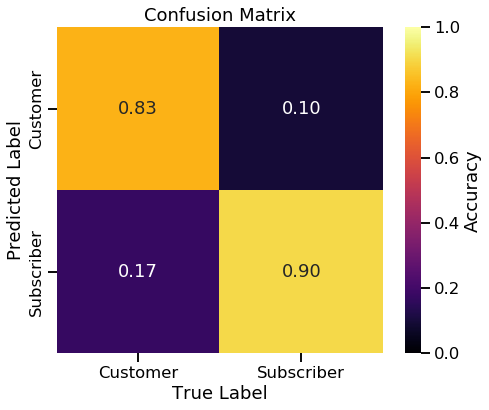

In [600]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

# Weather

## Data preparation for scikit-learn

In [46]:
# Drop all unrelevant columns and store new dataframe
if input('Load data for modeling? (y or n)') == 'y':
    df_model = feather.read_dataframe('data/2018_model_1.feather')
else:
    df_model = df.copy()

    #df_model.drop('starttime')
    df_model = df_model.drop(['starttime'], axis = 1)
    df_model = df_model.drop(['stoptime'], axis = 1)
    df_model = df_model.drop(['start station latitude'], axis = 1)
    df_model = df_model.drop(['start station longitude'], axis = 1)
    df_model = df_model.drop(['start station name'], axis = 1)
    df_model = df_model.drop(['end station latitude'], axis = 1)
    df_model = df_model.drop(['end station longitude'], axis = 1)
    df_model = df_model.drop(['end station name'], axis = 1)
    df_model = df_model.drop(['bikeid'], axis = 1)
    #df_model = df_model.drop(['start month'], axis = 1)
    #df_model = df_model.drop(['distance'], axis = 1)

    # replace weekday strings by numbers
    df_model['start weekday'] = pd.DatetimeIndex(df['starttime']).weekday

    feather.write_dataframe(df_model, 'data/2018_model_1.feather')

Load data for modeling? (y or n)y


In [47]:
# Prepare model dataframe as vectors for scikit learn
feature_cols_w = ['tripduration', 'speed', 'tmax',
                'start station id', 'end station id',
                'start weekday', 'start hour',
                'birth year', 'gender']

# you want all rows, and the feature_cols' columns
X_w = df_model.loc[:, feature_cols_w]
Y_w = df_model.loc[:, 'usertype']

In [48]:
# Create balanced dataset
x_cust_w = X_w[Y_w == 'Customer']
y_cust_w = Y_w[Y_w == 'Customer']

x_subs_w = X_w[Y_w == 'Subscriber']
y_subs_w = Y_w[Y_w == 'Subscriber']

# Shuffle subscriber data
x_subs_w = x_subs_w.sample(frac=1, random_state=42)

x_subs_w = x_subs_w.head(len(y_cust_w))
y_subs_w = y_subs_w[x_subs_w.index]
#y_subs = y_subs.head(len(y_cust))

x_bal_w = pd.concat((x_cust_w, x_subs_w))
y_bal_w = pd.concat((y_cust_w, y_subs_w))

## Visualization

/Users/fwinkler/anaconda3/envs/py3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


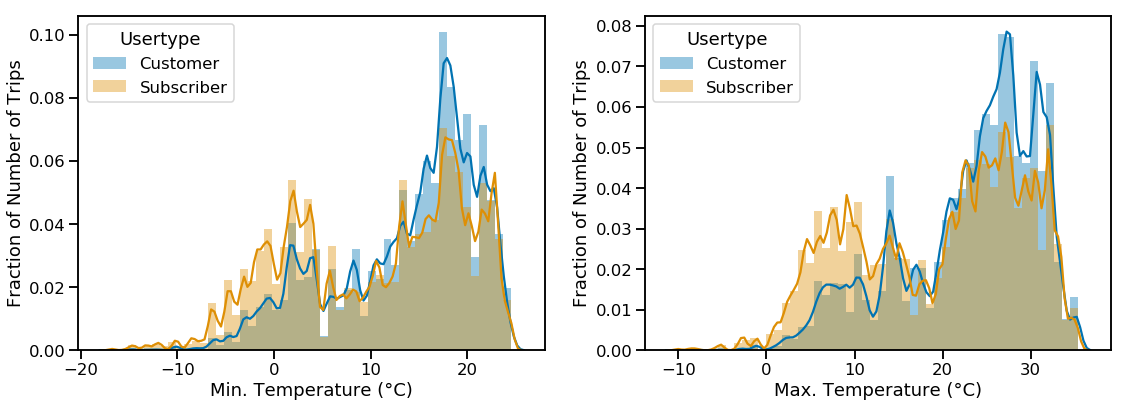

In [49]:
# Plot weahter
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
im0 = sns.distplot(df[df['usertype'] == 'Customer']['tmin'], label='Customer', 
                   color=palette[0], ax=axs[0])
im1 = sns.distplot(df[df['usertype'] == 'Subscriber']['tmin'], label='Subscriber', 
                   color=palette[1], ax=axs[0])
axs[0].legend(title='Usertype')
axs[0].set_xlabel('Min. Temperature (°C)')

sns.distplot(df[df['usertype'] == 'Customer']['tmax'], label='Customer', 
             color=palette[0], ax=axs[1])
sns.distplot(df[df['usertype'] == 'Subscriber']['tmax'], label='Subscriber', 
             color=palette[1], ax=axs[1])
axs[1].legend(title='Usertype')
axs[1].set_xlabel('Max. Temperature (°C)')

for ax in axs:
    ax.set_ylabel('Fraction of Number of Trips')
fig.tight_layout()
    
fig.savefig('Images/Tmin_Tmax.png', bbox_inches='tight', dpi=300)

## Model with weather (Random Forests)

In [608]:
model = RandomForestClassifier(n_estimators=20, max_depth=20, random_state=0, 
                               #class_weight='balanced', 
                               verbose=10, n_jobs=2)
model_name = 'model_forest_weather_balanced'

X_train, X_test, Y_train, Y_test = train_test_split(x_bal_w, y_bal_w, test_size=0.5, random_state=42)

In [609]:
# train model
if input('Load model "{}"? (y or n)'.format(model_name)) == 'y':
    model = load('models/{}.joblib'.format(model_name))
else:
    model.fit(X_train, Y_train);
    dump(model, 'models/{}.joblib'.format(model_name)) 

Load model "model_forest_weather_balanced"? (y or n)n


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 20building tree 2 of 20



[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:   17.0s


building tree 3 of 20
building tree 4 of 20
building tree 5 of 20


[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:   34.7s


building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20


[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:  1.2min


building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20


[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:  1.7min


building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.3min remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  2.3min finished


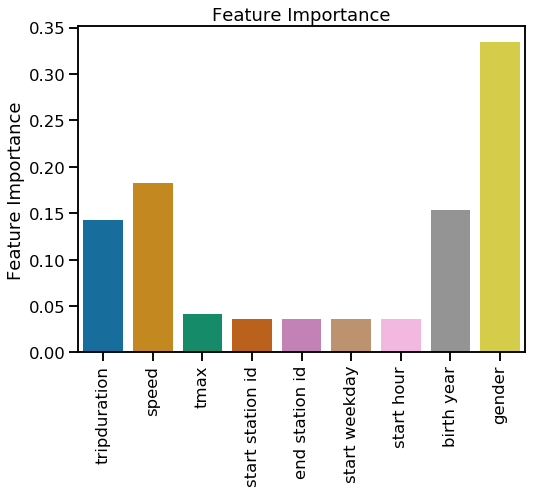

In [611]:
# Plot feature importancs
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.barplot(feature_cols_w, model.feature_importances_, palette=palette, ax=axs)
axs.set_xticklabels(axs.get_xticklabels(), rotation=90, ha='center', );
axs.set_xlabel('')
axs.set_ylabel('Feature Importance')
axs.set_title('Feature Importance')

fig.savefig('Images/feature_importance_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

In [247]:
# cross evaluation of model for 5 subsets of test data
if input('Load cross validation score? (y or n)') == 'y':
    cvs = np.load('crossvals/cross_val_score_{}.npy'.format(model_name))
else:
    cvs = cross_val_score(model, X_test, Y_test, cv=5)
    np.save('crossvals/cross_val_score_{}.npy'.format(model_name), cvs)
print(cvs)

Load cross validation score? (y or n)y
[0.86559691 0.86550624 0.86452507 0.86600985 0.8653383 ]


In [612]:
# evaluate the model for each usertype individually on the second set of data
for ut in ['Customer', 'Subscriber']:
    y_pred = model.predict(X_test[Y_test == ut])
    print(ut, accuracy_score(Y_test[Y_test == ut], y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.7s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    3.5s finished


Customer 0.8414194472253551


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    4.3s finished


Subscriber 0.8982255660668912


In [613]:
# evaluate the model overall on the second set of data
y_pred = model.predict(X_test)
print(accuracy_score(Y_test, y_pred))
print(balanced_accuracy_score(Y_test, y_pred))
#print(f1_score(Y_test, y_pred))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=2)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=2)]: Done   9 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:    5.8s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:    8.0s finished


0.8698396683076439
0.8698225066461232


In [614]:
# Calculate confusion matrix
mat = confusion_matrix(Y_test, y_pred)
mat = mat.astype('float') / mat.sum(axis=1)[:, np.newaxis]

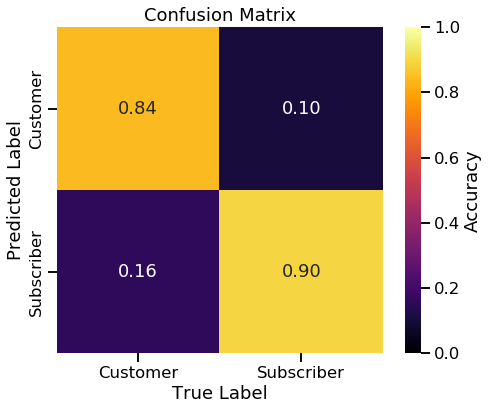

In [615]:
# Plot confusion matrix
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

sns.heatmap(mat.T, square=True, annot=True, 
            fmt='.2f',
            cbar=True,
            xticklabels=['Customer', 'Subscriber'],
            yticklabels=['Customer', 'Subscriber'],
            cmap=cmap,
            vmin=0, vmax=1,
            cbar_kws={'label': 'Accuracy'},
            ax=axs
           )

axs.set_xlabel('True Label')
axs.set_ylabel('Predicted Label')
axs.set_title('Confusion Matrix');

axs.set_yticklabels(axs.get_yticklabels(), va='center');

fig.savefig('Images/Confusion_matrix_{}.png'.format(model_name), bbox_inches='tight', dpi=300)

# Google maps api

In [50]:
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close

In [51]:
import googlemaps
from datetime import datetime
googmaps = googlemaps.Client(key=api_key)

In [52]:
# Prepare random subset of 200 subscriber rides
df_gmaps = df[df['usertype'] == 'Subscriber']

mean_dist = df_gmaps['distance'].mean()
std_dist = df_gmaps['distance'].std()
# only with trip distance that is +- 1 sigma from mean
df_gmaps = df_gmaps[(df_gmaps['distance'] > mean_dist - std_dist) & (df_gmaps['distance'] < mean_dist + std_dist)]

# randomly pick 200 of these
df_gmaps = df_gmaps.sample(frac=1, random_state=42)

df_gmaps = df_gmaps.head(200)

In [53]:
# Calculate distance and duration of "transits"
now = datetime.now()
mode = 'transit'
try:
    transit_dur = np.load('data/transit_dur.npy')
    transit_dis = np.load('data/transit_dis.npy')
except:
    transit_dur, transit_dis = [], []
    for i in df_gmaps.index:
        start = (df_gmaps.loc[i]['start station latitude'], df_gmaps.loc[i]['start station longitude'])
        end = (df_gmaps.loc[i]['end station latitude'], df_gmaps.loc[i]['end station longitude'])

        # check format of time
        time = df_gmaps.loc[i]['starttime'].to_pydatetime()
        time = time.replace(year=now.year, month=now.month, day=now.day+1)

        directions_result = googmaps.directions(start, end,
                                            mode=mode, avoid='ferries',
                                            departure_time=time, 
                                            units='metric'
                                           )

        dur = directions_result[0]['legs'][0]['duration']['value']
        dis = directions_result[0]['legs'][0]['distance']['value']

        transit_dur.append(dur)
        transit_dis.append(dis)

    np.save('data/transit_dur.npy', transit_dur)
    np.save('data/transit_dis.npy', transit_dis)

In [54]:
# Calculate distance and duration of "transits"
now = datetime.now()
mode = 'driving'
try:
    car_dur = np.load('data/car_dur.npy')
    car_dis = np.load('data/car_dis.npy')
except:
    car_dur, car_dis = [], []
    for i in df_gmaps.index:
        start = (df_gmaps.loc[i]['start station latitude'], df_gmaps.loc[i]['start station longitude'])
        end = (df_gmaps.loc[i]['end station latitude'], df_gmaps.loc[i]['end station longitude'])

        # check format of time
        time = df_gmaps.loc[i]['starttime'].to_pydatetime()
        time = time.replace(year=now.year, month=now.month, day=now.day+1)

        directions_result = googmaps.directions(start, end,
                                            mode=mode, avoid='ferries',
                                            departure_time=time, 
                                            units='metric'
                                           )

        dur = directions_result[0]['legs'][0]['duration']['value']
        dis = directions_result[0]['legs'][0]['distance']['value']

        car_dur.append(dur)
        car_dis.append(dis)

    np.save('data/car_dur.npy', car_dur)
    np.save('data/car_dis.npy', car_dis)

In [55]:
# Add data from google maps to dataframe
df_gmaps['duration_car'] = car_dur
df_gmaps['duration_transit'] = transit_dur
df_gmaps['distance_car'] = car_dis
df_gmaps['distance_transit'] = transit_dis

In [56]:
df_gmaps['distance'].max()

3123.2914793500904

In [57]:
# metrics car
faster_than_car = len(np.where(df_gmaps['tripduration'] - df_gmaps['duration_car'] <= 0)[0])
faster_than_car /= len(df_gmaps)
time_saved_car = np.mean(df_gmaps['tripduration'] - df_gmaps['duration_car'])
print('In {:.0f}% of the test rides, the citibike rider was faster than by car'.format(100*faster_than_car))
print('The median time difference is {:.1f} s'.format(time_saved_car))

print('\n ---------- \n')
# metrics transit
faster_than_transit = len(np.where(df_gmaps['tripduration'] - df_gmaps['duration_transit'] <= 0)[0])
faster_than_transit /= len(df_gmaps)
time_saved_transit = np.mean(df_gmaps['tripduration'] - df_gmaps['duration_transit'])
print('In {:.0f}% of the test rides, the citibike rider was faster than by public transport'.format(100*faster_than_transit))
print('The median time difference is {:.1f} s'.format(time_saved_transit))

In 52% of the test rides, the citibike rider was faster than by car
The median time difference is 46.1 s

 ---------- 

In 88% of the test rides, the citibike rider was faster than by public transport
The median time difference is -269.3 s


/Users/fwinkler/anaconda3/envs/py3.7/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


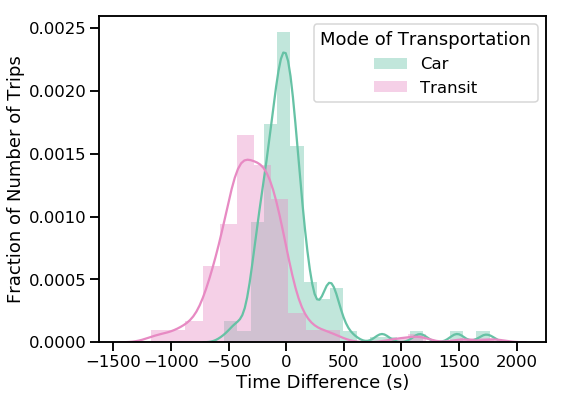

In [62]:
# Plot saved time
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.distplot(df_gmaps['tripduration'] - df_gmaps['duration_car'], 20, label='Car', 
             color=palette_2[0], ax=axs)
sns.distplot(df_gmaps['tripduration'] - df_gmaps['duration_transit'], 20, label='Transit', 
             color=palette_2[3], ax=axs)
axs.legend(title='Mode of Transportation')

#axs.set_title('Distribution of Time Differences \n to other means of transportation')
axs.set_xlabel('Time Difference (s)')
axs.set_ylabel('Fraction of Number of Trips')

fig.savefig('Images/Saved_Time.png', bbox_inches='tight', dpi=300)

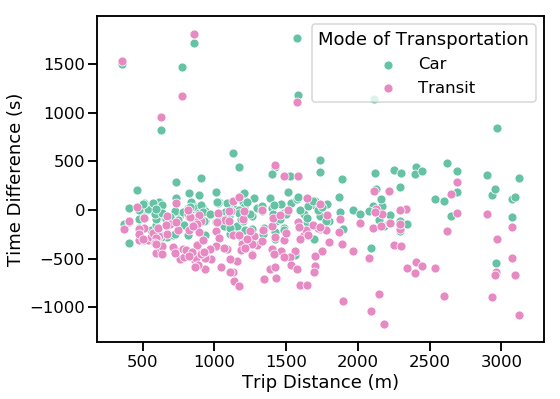

In [61]:
# Plot saved Time vs distance
fig, axs = plt.subplots(1, 1, figsize=(8, 6))
sns.scatterplot(x=df_gmaps['distance'], y=df_gmaps['tripduration'] - df_gmaps['duration_car'], 
                label='Car', color=palette_2[0], ax=axs)
sns.scatterplot(x=df_gmaps['distance'], y=df_gmaps['tripduration'] - df_gmaps['duration_transit'], 
                label='Transit', color=palette_2[3], ax=axs)
axs.legend(title='Mode of Transportation')
axs.set_ylabel('Time Difference (s)')
axs.set_xlabel('Trip Distance (m)')

fig.savefig('Images/Saved_Time_vs_Distance.png', bbox_inches='tight', dpi=300)

# NYPD data

In [64]:
# Load the data
if os.path.isfile('data/NYPD_Motor_Vehicle_Collisions.feather'):
    df_nypd = feather.read_dataframe('data/NYPD_Motor_Vehicle_Collisions.feather')
else:
    df_nypd = pd.read_csv('data/NYPD_Motor_Vehicle_Collisions.csv')
    # Drop empty rows
    df_nypd = df_nypd.dropna(how='all')
    # Drop ZIP Code
    df_nypd = df_nypd.drop(['ZIP CODE'], axis = 1)
    feather.write_dataframe(df_nypd, 'data/NYPD_Motor_Vehicle_Collisions.feather')

/Users/fwinkler/anaconda3/envs/py3.7/lib/python3.7/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [65]:
df_nypd_bike = df_nypd[(df_nypd['VEHICLE TYPE CODE 1'] == 'Bike') | 
                       (df_nypd['VEHICLE TYPE CODE 2'] == 'Bike') |
                       (df_nypd['VEHICLE TYPE CODE 3'] == 'Bike') |
                       (df_nypd['VEHICLE TYPE CODE 4'] == 'Bike') |
                       (df_nypd['VEHICLE TYPE CODE 5'] == 'Bike')]

In [66]:
n_coll_tot = len(df_nypd)
n_coll_bike_injured = len(df_nypd[df_nypd['NUMBER OF CYCLIST INJURED'] != 0])
n_coll_bike_killed = len(df_nypd[df_nypd['NUMBER OF CYCLIST KILLED'] != 0])
n_coll_bike_involved = len(df_nypd_bike)
print('In {:.3f} % of collisions was a cyclist involved'.format(100*n_coll_bike_involved / n_coll_tot))
print('In {:.3f} % of collisions was a cyclist injured'.format(100*n_coll_bike_injured / n_coll_tot))
print('In {:.3f} % of collisions was a cyclist killed'.format(100*n_coll_bike_killed / n_coll_tot))

In 0.535 % of collisions was a cyclist involved
In 2.036 % of collisions was a cyclist injured
In 0.008 % of collisions was a cyclist killed


In [67]:
df_nypd_bike.columns

Index(['DATE', 'TIME', 'BOROUGH', 'LATITUDE', 'LONGITUDE', 'LOCATION',
       'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
       'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
       'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
       'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED',
       'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
       'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
       'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
       'CONTRIBUTING FACTOR VEHICLE 5', 'UNIQUE KEY', 'VEHICLE TYPE CODE 1',
       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
       'VEHICLE TYPE CODE 5'],
      dtype='object')

In [68]:
df_nypd_bike = df_nypd_bike.dropna(subset=['LONGITUDE', 'LATITUDE'])
df_nypd_bike = df_nypd_bike[(df_nypd_bike['LATITUDE'] != 0) | (df_nypd_bike['LONGITUDE'] != 0)]

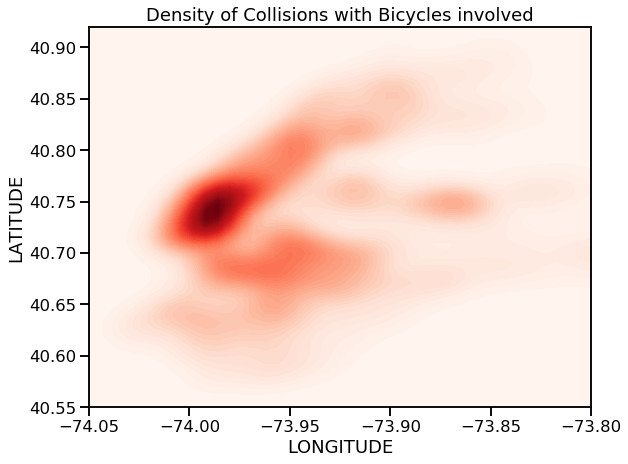

In [69]:
fig, axs = plt.subplots(1, 1, figsize=(9, 7))
sns.kdeplot(df_nypd_bike['LONGITUDE'], df_nypd_bike['LATITUDE'], 
            cmap='Reds', n_levels=60, shade=True, ax=axs, cbar=False, vmin=0)
axs.set_ylim(40.55, 40.92)
axs.set_xlim(-74.05, -73.8)
axs.set_title('Density of Collisions with Bicycles involved')

fig.savefig('Images/Collisions_location_density.png', bbox_inches='tight', dpi=300)

In [705]:
df_nypd['VEHICLE TYPE CODE 2'].unique()

array(['Station Wagon/Sport Utility Vehicle', None, 'Bus', 'Sedan',
       'Pick-up Truck', 'unkno', 'Taxi', 'Garbage or Refuse', 'Box Truck',
       'Bike', 'Motorcycle', 'Van', 'Tractor Truck Diesel', 'PK',
       'Chassis Cab', 'Carry All', 'Flat Bed', 'Concrete Mixer',
       'Ambulance', 'VAN T', 'Elect', 'nyfd', 'Moped',
       'Tow Truck / Wrecker', 'Convertible', '3-Door', 'TOWIN', 'Dump',
       'Pickup with mounted Camper', 'TRUCK', 'MOPED', 'Motorbike',
       'Tractor Truck Gasoline', 'AMBUL', 'Armored Truck', 'US PO',
       'MAN B', 'Stake or Rack', 'Tow Truck', 'Pedicab', 'lift', 'E-BIK',
       'Motorized Home', 'Flat Rack', 'Refrigerated Van',
       'Enclosed Body - Removable Enclosure', 'Multi-Wheeled Vehicle',
       'Forkl', 'Tanker', 'const', 'Motorscooter', 'Bulk Agriculture',
       'Deliv', 'Bucke', 'VAN C', 'firet', 'Lift Boom', 'van',
       'School Bus', 'Ambul', 'UNK', 'AMB', 'E Bik', 'TRAIL', 'speci',
       'ELECT', 'RD/S', 'STREE', 'c7c', 'pick', 'FIRE',